### Setup

In [133]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100) 

from os import path
import pickle

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures

from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Import Data

In [2]:
f = 'loan_clean.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'rb') as file:
    data = pickle.load(file)

In [3]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,had_delinq,had_major_derog,had_record,annual_inc_merged,dti_merged,rev_util_custom,verification_status_merged,earliest_cr_line_td,default,default_harsh
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10139658,12000.0,12000.0,12000.0,36 months,13.53,407.40,B,B5,10+ years,RENT,40000.0,Source Verified,2013-12-01,Fully Paid,n,debt_consolidation,871xx,NM,16.94,0.0,1998-10-01,0.0,7.0,2.0,5572.0,68.8,32.0,w,0.00,0.00,13359.770000,13359.77,11999.99,1359.78,0.0,0.0,0.0,119.17,0.0,1.0,INDIVIDUAL,0.0,15386.0,13605.0,8100.0,1,1,1,40000.0,16.94,68.8,Source Verified,-5540,0,0
10179520,3000.0,3000.0,3000.0,36 months,12.85,100.87,B,B4,10+ years,RENT,25000.0,Verified,2013-12-01,Fully Paid,n,debt_consolidation,322xx,FL,24.68,0.0,1991-05-01,0.0,5.0,2.0,2875.0,54.2,26.0,f,0.00,0.00,3181.532981,3181.53,3000.00,181.53,0.0,0.0,0.0,2677.23,0.0,1.0,INDIVIDUAL,0.0,154.0,19530.0,5300.0,1,1,1,25000.0,24.68,54.2,Verified,-8250,0,0
10149577,28000.0,28000.0,28000.0,36 months,7.62,872.52,A,A3,5 years,MORTGAGE,325000.0,Source Verified,2013-12-01,Fully Paid,n,debt_consolidation,945xx,CA,18.55,0.0,1994-11-01,1.0,15.0,0.0,29581.0,54.6,31.0,w,0.00,0.00,29150.980000,29150.98,28000.00,1150.98,0.0,0.0,0.0,23915.86,0.0,1.0,INDIVIDUAL,0.0,0.0,799592.0,54200.0,0,0,0,325000.0,18.55,54.6,Source Verified,-6970,0,0
10127816,24000.0,24000.0,24000.0,36 months,13.53,814.80,B,B5,10+ years,MORTGAGE,100000.0,Verified,2013-12-01,Fully Paid,n,credit_card,493xx,MI,22.18,0.0,1989-01-01,0.0,14.0,0.0,21617.0,76.7,39.0,w,0.00,0.00,28652.210000,28652.21,24000.00,4652.21,0.0,0.0,0.0,10726.61,0.0,1.0,INDIVIDUAL,0.0,539.0,199834.0,28200.0,0,0,0,100000.0,22.18,76.7,Verified,-9100,0,0
10149566,8000.0,8000.0,8000.0,36 months,10.99,261.88,B,B2,2 years,MORTGAGE,33000.0,Not Verified,2013-12-01,Late (31-120 days),n,debt_consolidation,800xx,CO,15.75,0.0,1991-07-01,1.0,9.0,1.0,7203.0,34.6,16.0,f,4145.19,4145.19,4990.030000,4990.03,3854.81,1120.22,15.0,0.0,0.0,276.88,0.0,1.0,INDIVIDUAL,0.0,0.0,15949.0,20800.0,0,0,1,33000.0,15.75,34.6,Not Verified,-8189,0,1


### Data Cleaning

Based off the experience thus far with the classification MVP, one of the more limiting factors has been model performance and computational demand due to both then number of instances in the Lending Club and the number features used and/or created. Consequently, moving forward with this regression analysis we will try to reduce the load for both training instances and features in the hopes of streamlining this analysis.

Taking a look at our dataset as-is:

In [4]:
data.isnull().sum()

loan_amnt                       0
funded_amnt                     0
funded_amnt_inv                 0
term                            0
int_rate                        0
installment                     0
grade                           0
sub_grade                       0
emp_length                      0
home_ownership                  0
annual_inc                      0
verification_status             0
issue_d                         0
loan_status                     0
pymnt_plan                      0
purpose                         0
zip_code                        0
addr_state                      0
dti                             0
delinq_2yrs                     0
earliest_cr_line                0
inq_last_6mths                  0
open_acc                        0
pub_rec                         0
revol_bal                       0
revol_util                    131
total_acc                       0
initial_list_status             0
out_prncp                       0
out_prncp_inv 

In [5]:
data.shape

(204264, 55)

revol_util is the only data we are missing, so for the aforementioned sake of simplicity we will remove these records:

In [6]:
data.dropna(inplace=True)

Additionally, as highlighted during data cleaning this dataset still includes late loans for the optional 'default_harsh' status column. For the sake of this MVP, we will discard these records and focus on the traditional default status based off only fully paid vs. charged off/default.

In [7]:
data['loan_status'].value_counts()

Fully Paid            153937
Charged Off            35206
Late (31-120 days)     11462
Late (16-30 days)       2328
Default                 1200
Name: loan_status, dtype: int64

In [8]:
mask_late = data['loan_status'].str.contains('Late')

data = data[~mask_late].copy()

In [9]:
# Drop alternative default status column
data.drop('default_harsh', axis=1, inplace=True)

In [10]:
data['loan_status'].value_counts()

Fully Paid     153937
Charged Off     35206
Default          1200
Name: loan_status, dtype: int64

Finally, the focus of this regression analysis is the return on loans that have defaulted, so all loans with a status of non-default should be removed from the dataset:

In [11]:
mask_default = data['default'] == 1

data = data[mask_default].copy()

In [12]:
data.shape[0]

36406

We are left with approx. 36,406 records. The alternate approach of including late loans can be left for subsequent analysis if the need arises - perhaps it will help in providing additional records since the current set has been reduced drastically.

### Target Variable

For the purpose of this regression analysis, we are interested in the total return for a given loan. The column for 'total_pymnt' should capture the amount paid over the course of the loan. Thus, to obtain the profit/return we should be able to compare this total payment with the initial amount funded:

In [13]:
net_return = data['total_pymnt'] - data['funded_amnt']

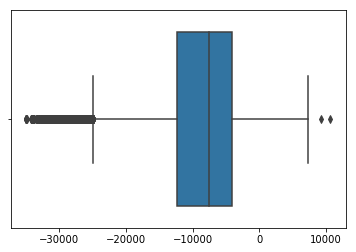

In [14]:
sns.boxplot(net_return)
plt.show()

In [15]:
(net_return > 0).sum()

547

In [16]:
(net_return > 0).sum() / data.shape[0]

0.015024995879800032

Only 1.5% of defaulted loans see a positive return, which is obviously a very small fraction. This may pose complications in our modelling since fitting to these select few instances may lead to general overfitting.

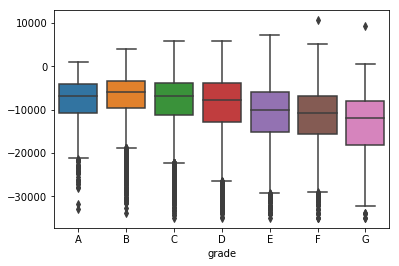

In [17]:
grades = list('ABCDEFG')
grades_mapping = {grade: i for i, grade in enumerate(grades)}
grades_key = data['grade'].map(grades_mapping)

sns.boxplot(data.iloc[grades_key.argsort()]['grade'], net_return)

plt.show()

In [18]:
# Rough ROI (does not account for time)
roi = net_return / data['funded_amnt']

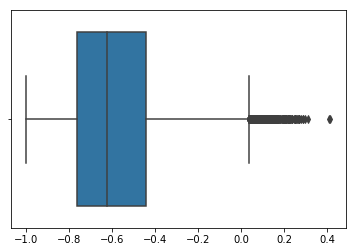

In [19]:
sns.boxplot(roi)
plt.show()

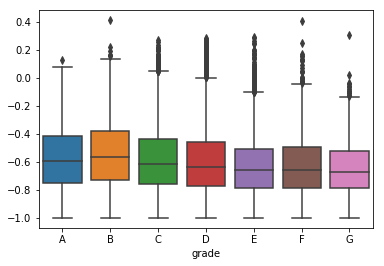

In [20]:
sns.boxplot(data.iloc[grades_key.argsort()]['grade'], roi)

plt.show()

In [21]:
data['profit'] = net_return
#target = data['profit']

### Feature Selection

In [22]:
grade_map = {grade: i for i, grade in enumerate('ABCDEFG')}
grade_map

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}

In [23]:
subgrade_map = {sg: grade_map[sg[0]]*10 + int(sg[1]) for sg in [c + str(i) for c in 'ABCDEFG' for i in range(1,6)]}
subgrade_map

{'A1': 1,
 'A2': 2,
 'A3': 3,
 'A4': 4,
 'A5': 5,
 'B1': 11,
 'B2': 12,
 'B3': 13,
 'B4': 14,
 'B5': 15,
 'C1': 21,
 'C2': 22,
 'C3': 23,
 'C4': 24,
 'C5': 25,
 'D1': 31,
 'D2': 32,
 'D3': 33,
 'D4': 34,
 'D5': 35,
 'E1': 41,
 'E2': 42,
 'E3': 43,
 'E4': 44,
 'E5': 45,
 'F1': 51,
 'F2': 52,
 'F3': 53,
 'F4': 54,
 'F5': 55,
 'G1': 61,
 'G2': 62,
 'G3': 63,
 'G4': 64,
 'G5': 65}

In [24]:
data['grade_val'] = data['grade'].map(grade_map)
data['subgrade_val'] = data['sub_grade'].map(subgrade_map)

In [25]:
num_attr = ['funded_amnt', 'int_rate', 'installment', 'annual_inc_merged', 'dti_merged', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collection_recovery_fee', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'total_rev_hi_lim', 'tot_cur_bal', 'tot_coll_amt',
            'grade_val', 'subgrade_val']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record']

cat_attr = ['emp_length', 'purpose', 'home_ownership', 'verification_status_merged', 'application_type', 'term']

In [26]:
# Class for selecting attributes from a dataframe, for use in pipelines

class DataFrame_Selector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [27]:
class DataFrame_DummyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        dummies = pd.get_dummies(X[self.attribute_names])
        return dummies.values

In [28]:
num_select = DataFrame_Selector(num_attr)

bin_select = DataFrame_Selector(bin_attr)

cat_select = DataFrame_DummyEncoder(cat_attr)

In [29]:
#data_prepared = prep_pipeline.fit_transform(data)

In [30]:
#data_prepared.shape

### Modeling

##### Train/Test Split

In [31]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [32]:
(train['profit'] > 0).sum() / train.shape[0]

0.01534816646065101

In [33]:
(test['profit'] > 0).sum() / test.shape[0]

0.013732491073880802

In [34]:
y_train = train['profit']
y_test = test['profit']

##### Linear Regression

In [38]:
num_prep = Pipeline([('select', num_select),
                     ('sc', StandardScaler())])

In [39]:
feature_prep = FeatureUnion([('num', num_prep),
                          ('bin', bin_select),
                          ('cat', cat_select)])

In [52]:
X_train = feature_prep.fit_transform(train)
X_test = feature_prep.fit_transform(test)

In [53]:
linreg = LinearRegression(n_jobs=4)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

In [54]:
linreg.score(X_train, y_train)

0.73524967755942428

In [56]:
linreg.score(X_test, y_test)

0.73926831865671405

In [59]:
ridge_reg = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

ridge_gs = GridSearchCV(estimator=ridge_reg,
                  param_grid = param_grid,
                  cv=3,
                  n_jobs=4)

ridge_gs.fit(X_train, y_train);

In [60]:
ridge_gs.best_params_

{'alpha': 0.1}

In [61]:
ridge_gs.best_score_

0.73401285673045247

In [62]:
ridge_best = ridge_gs.best_estimator_

In [64]:
ridge_best.score(X_train, y_train)

0.73526083854782098

In [65]:
ridge_best.score(X_test, y_test)

0.73934455945579725

In [67]:
lasso_reg = Lasso()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'max_iter': [2000]}

lasso_gs = GridSearchCV(estimator=lasso_reg,
                  param_grid = param_grid,
                  cv=3,
                  n_jobs=4)

lasso_gs.fit(X_train, y_train);

In [68]:
lasso_gs.best_params_

{'alpha': 1, 'max_iter': 2000}

In [69]:
lasso_gs.best_score_

0.73404382572007609

In [84]:
lasso_best = lasso_gs.best_estimator_

In [85]:
lasso_best.score(X_train, y_train)

0.73519721788123904

In [86]:
lasso_best.score(X_test, y_test)

0.73936408265491171

In [78]:
elastic_reg = ElasticNet()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'l1_ratio': np.arange(0,1.1,0.1),
              'max_iter': [2000]}

elastic_gs = GridSearchCV(estimator=elastic_reg,
                  param_grid = param_grid,
                  cv=3,
                  n_jobs=4)

elastic_gs.fit(X_train, y_train);

In [79]:
elastic_gs.best_params_

{'alpha': 1, 'l1_ratio': 1.0, 'max_iter': 2000}

In [80]:
elastic_gs.best_score_

0.73404382572007609

Pure L1 (lasso) had highest score.

In [81]:
elastic_best = elastic_gs.best_estimator_

In [82]:
elastic_best.score(X_train, y_train)

0.73519721788123904

In [83]:
elastic_best.score(X_test, y_test)

0.73936408265491171

##### Polynomial Regression

In [112]:
# Only want to create polynomial features for the numerical terms
num_prep = Pipeline([('select', num_select),
                     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
                     ('sc', StandardScaler())])

In [113]:
poly_prep = FeatureUnion([('num', num_prep),
                          ('bin', bin_select),
                          ('cat', cat_select)])

In [93]:
X_train = poly_prep.fit_transform(train)
X_test = poly_prep.fit_transform(test)

In [95]:
quad_linreg = LinearRegression(n_jobs=4)
quad_linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

In [96]:
quad_linreg.score(X_train, y_train)

0.76197625815257264

In [97]:
quad_linreg.score(X_test, y_test)

0.75511859799128722

In [99]:
quad_elastic = ElasticNet()

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100],
              'l1_ratio': np.arange(0,1.1,0.2),
              'max_iter': [5000],
              'tol': [0.001]}

quad_elastic_gs = GridSearchCV(estimator=quad_elastic,
                  param_grid = param_grid,
                  cv=3,
                  n_jobs=4)

quad_elastic_gs.fit(X_train, y_train);

C:\Users\David\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [101]:
quad_elastic_gs.best_params_

{'alpha': 1, 'l1_ratio': 1.0, 'max_iter': 5000, 'tol': 0.001}

In [103]:
quad_elastic_gs.best_score_

0.75100599988110239

In [104]:
quad_elastic_gs.best_estimator_.score(X_test, y_test)

0.7574275861004881

Pure lasso appears to be most effective.

In [109]:
quad_lasso = Lasso(alpha=1, tol=0.001, max_iter=10000)
quad_lasso.fit(X_train, y_train)

C:\Users\David\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.001, warm_start=False)

In [110]:
quad_lasso.score(X_train, y_train)

0.75946890524803479

In [111]:
quad_lasso.score(X_test, y_test)

0.75750139332599098

In [115]:
poly_prep.set_params(num__poly__degree = 3)
X_train = poly_prep.fit_transform(train)
X_test = poly_prep.fit_transform(test)

In [117]:
cubic_linreg = LinearRegression(n_jobs=4)

In [118]:
cubic_linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

In [119]:
cubic_linreg.score(X_train, y_train)

0.79109490139567373

In [120]:
cubic_linreg.score(X_test, y_test)

-30246990585177632.0

In [122]:
cubic_lasso = Lasso(tol=.01, max_iter=2000)

In [123]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

cubic_lasso_gs = GridSearchCV(estimator=cubic_lasso,
                  param_grid = param_grid,
                  cv=3,
                  n_jobs=4)

cubic_lasso_gs.fit(X_train, y_train);

In [124]:
cubic_lasso_gs.best_params_

{'alpha': 10}

In [125]:
cubic_lasso_gs.best_score_

0.74740004584748199

In [126]:
cubic_lasso_gs.best_estimator_.score(X_test, y_test)

0.74868396403194315

##### Support Vector Regression

In [127]:
num_prep = Pipeline([('select', num_select),
                     ('sc', StandardScaler())])

In [128]:
svr_prep = FeatureUnion([('num', num_prep),
                          ('bin', bin_select),
                          ('cat', cat_select)])

In [130]:
X_train = svr_prep.fit_transform(train)
X_test = svr_prep.fit_transform(test)

In [145]:
svr_linear = LinearSVR(loss='squared_epsilon_insensitive', dual=False, tol=0.0001)

In [146]:
svr_linear.fit(X_train, y_train)

LinearSVR(C=1.0, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [147]:
svr_linear.score(X_train, y_train)

0.7352599236015317

In [148]:
svr_linear.score(X_test, y_test)

0.7393459157857416

In [151]:
y_train.describe()

count    29124.000000
mean     -8931.745149
std       6416.887547
min     -35000.000000
25%     -12390.250000
50%      -7632.360000
75%      -4064.450000
max      10626.190000
Name: profit, dtype: float64

In [152]:
param_grid = {'C': np.logspace(-6,3,10),
              'epsilon': [0, 100, 200, 500, 1000, 2000, 5000]}

svr_lin_l1_gs = GridSearchCV(estimator=LinearSVR(loss='epsilon_insensitive', dual=True),
                             param_grid=param_grid,
                             cv=3,
                             n_jobs=2)

svr_lin_l1_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'C': array([  1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'epsilon': [0, 100, 200, 500, 1000, 2000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [153]:
param_grid = {'C': np.logspace(-6,3,10),
              'epsilon': [0, 100, 200, 500, 1000, 2000, 5000]}

svr_lin_l2_gs = GridSearchCV(estimator=LinearSVR(loss='squared_epsilon_insensitive', dual=False),
                             param_grid=param_grid,
                             cv=3,
                             n_jobs=2)

svr_lin_l2_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'C': array([  1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'epsilon': [0, 100, 200, 500, 1000, 2000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [154]:
svr_lin_l1_gs.best_score_, svr_lin_l2_gs.best_score_

(0.73146413213659778, 0.73403112221232258)

In [155]:
svr_lin_l2_gs.best_params_

{'C': 1.0, 'epsilon': 0}

In [156]:
svr_lin_best = svr_lin_l2_gs.best_estimator_

In [157]:
svr_lin_best.score(X_test, y_test)

0.7393459157857416

In [160]:
svr_quad = SVR(kernel='poly', degree=2)

In [161]:
svr_quad.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [162]:
svr_quad.score(X_train, y_train)

-0.011984714726885892

In [163]:
svr_quad.score(X_test, y_test)

-0.010301326419782209

In [167]:
svr_quad.set_params(C=10, gamma=0.01)

SVR(C=10, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma=0.01,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [168]:
svr_quad.fit(X_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma=0.01,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [169]:
svr_quad.score(X_train, y_train)

0.050563558518464946

In [170]:
svr_quad.score(X_test, y_test)

0.054943158237459211

In [175]:
svr_quad.set_params(C=.01, gamma=0.01)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma=0.01,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [176]:
svr_quad.fit(X_train, y_train)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma=0.01,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [177]:
svr_quad.score(X_train, y_train)

-0.040902331231819078

In [178]:
svr_quad.score(X_test, y_test)

-0.04055543178397758

In [179]:
svr_rbf = SVR(kernel='rbf')

In [180]:
svr_rbf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [181]:
svr_rbf.score(X_train, y_train)

0.13830263098852491

In [182]:
svr_rbf.score(X_test, y_test)

0.14151195981962417

In [183]:
svr_rbf.set_params(C=10, gamma=0.001)
svr_rbf.fit(X_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [184]:
svr_rbf.score(X_train, y_train)

0.17072737759055157

In [185]:
svr_rbf.score(X_test, y_test)

0.1780653100968842

##### Decision Tree Regressor

In [186]:
dtr = DecisionTreeRegressor()

In [196]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [189]:
dtr.score(X_train, y_train)

1.0

In [190]:
dtr.score(X_test, y_test)

0.450034567594916

In [191]:
dtr.tree_.max_depth

42

In [207]:
param_grid = {'criterion': ['mse', 'mae', 'friedman_mse'],
              'splitter': ['random', 'best'],
              'max_depth': np.arange(10,40,5),
              'min_samples_split': np.arange(5,201,5),
              'min_samples_leaf': np.arange(5,201,5),
              'max_features': np.arange(0.1,1.0,0.1)}

dtr_rs = RandomizedSearchCV(estimator=DecisionTreeRegressor(),
                            param_distributions=param_grid,
                            cv=3,
                            n_iter=200,
                            n_jobs=4)

dtr_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
          fit_params=None, iid=True, n_iter=200, n_jobs=4,
          param_distributions={'criterion': ['mse', 'mae', 'friedman_mse'], 'splitter': ['random', 'best'], 'max_depth': array([10, 15, 20, 25, 30, 35]), 'min_samples_split': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 1...185, 190, 195, 200]), 'max_features': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [208]:
dtr_rs.best_score_

0.70376646577696633

In [209]:
dtr_rs.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 30,
 'max_features': 0.80000000000000004,
 'min_samples_leaf': 20,
 'min_samples_split': 65,
 'splitter': 'best'}

In [210]:
dtr_rs.best_estimator_.score(X_test, y_test)

0.67479497561793345

In [226]:
# Only want to create polynomial features for the numerical terms
num_prep = Pipeline([('select', num_select),
                     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
                     ('sc', StandardScaler())])

In [227]:
poly_prep = FeatureUnion([('num', num_prep),
                          ('bin', bin_select),
                          ('cat', cat_select)])

In [228]:
X_train = poly_prep.fit_transform(train)
X_test = poly_prep.fit_transform(test)

In [234]:
param_grid = {'criterion': ['friedman_mse'],
              'splitter': ['best'],
              'max_depth': np.arange(10,45,5),
              'min_samples_split': np.arange(5,201,5),
              'min_samples_leaf': np.arange(5,201,5),
              'max_features': np.arange(0.1,1.0,0.1)}

dtr_poly_rs = RandomizedSearchCV(estimator=DecisionTreeRegressor(),
                            param_distributions=param_grid,
                            cv=3,
                            n_iter=200,
                            n_jobs=2)

dtr_poly_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
          fit_params=None, iid=True, n_iter=200, n_jobs=2,
          param_distributions={'criterion': ['friedman_mse'], 'splitter': ['best'], 'max_depth': array([10, 15, 20, 25, 30, 35, 40]), 'min_samples_split': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135,...185, 190, 195, 200]), 'max_features': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [235]:
dtr_poly_rs.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 15,
 'max_features': 0.90000000000000002,
 'min_samples_leaf': 50,
 'min_samples_split': 165,
 'splitter': 'best'}

In [236]:
dtr_poly_best = dtr_poly_rs.best_estimator_

In [237]:
dtr_poly_best.score(X_train, y_train)

0.74829582858978916

In [238]:
dtr_poly_best.score(X_test, y_test)

0.66287855853526934

Increased overfitting. If we are to proceed with polynomial features and decision trees, more must be done prior to modelling to select those polynomial that are actually beneficial.

##### Random Forest Regressor

In [240]:
num_prep = Pipeline([('select', num_select),
                     ('sc', StandardScaler())])

In [241]:
svr_prep = FeatureUnion([('num', num_prep),
                          ('bin', bin_select),
                          ('cat', cat_select)])

In [242]:
X_train = svr_prep.fit_transform(train)
X_test = svr_prep.fit_transform(test)

In [245]:
rfr = RandomForestRegressor(n_estimators=10,
                            criterion='friedman_mse',
                            max_depth=30,
                            max_features=0.8,
                            min_samples_leaf=20,
                            min_samples_split=60,
                            n_jobs=4)

In [246]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=30,
           max_features=0.8, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=60,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [247]:
rfr.score(X_train, y_train)

0.78753330325088322

In [248]:
rfr.score(X_test, y_test)

0.7228706066700008

In [253]:
rfr.set_params(n_estimators=50)

RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=30,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=60,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [254]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=30,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=60,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [255]:
rfr.score(X_train, y_train)

0.78111362446172083

In [256]:
rfr.score(X_test, y_test)

0.72618470898129506

In [264]:
param_grid = {'criterion': ['friedman_mse'],
              'bootstrap': [True, False],
              'max_depth': np.arange(10,45,5),
              'min_samples_split': np.arange(10,201,10),
              'min_samples_leaf': np.arange(10,201,10),
              'max_features': np.arange(0.1,1.0,0.1)}

rfr_rs = RandomizedSearchCV(estimator=RandomForestRegressor(),
                            param_distributions=param_grid,
                            cv=3,
                            n_iter=200,
                            n_jobs=2)

rfr_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=200, n_jobs=2,
          param_distributions={'criterion': ['friedman_mse'], 'bootstrap': [True, False], 'max_depth': array([10, 15, 20, 25, 30, 35, 40]), 'min_samples_split': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200]), 'min_samples_leaf': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200]), 'max_features': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])}

In [265]:
rfr_rs.best_score_

0.73131136239684402

In [266]:
rfr_rs.best_params_

{'bootstrap': True,
 'criterion': 'friedman_mse',
 'max_depth': 30,
 'max_features': 0.90000000000000002,
 'min_samples_leaf': 10,
 'min_samples_split': 70}

In [267]:
rfr_rs.best_estimator_.score(X_test, y_test)

0.72022581161827359